In [1]:
#####Binomial Probit Based Tucker Decomposition#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [3]:
####データの発生####
##データの設定
type_n = 3
k1 = 10
k2 = 10
k3 = 7
hh = 5000   #ユーザー数
item = 4000   #アイテム数
context = 500   #コンテキスト数
Lambda = np.random.gamma(30.0, 1/0.2, hh)
pt = np.random.poisson(Lambda, hh)   #ユーザーあたりのレコード数
freq = np.random.poisson(25.0, np.sum(pt)); freq[freq < 3] = 3
hhpt = np.sum(pt)
N = np.sum(freq)
vec_k1 = np.repeat(1, k1); vec_k2 = np.repeat(1, k2); vec_k3 = np.repeat(1, k3)

In [4]:
##IDとインデックスを作成
#IDの作成
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = index[d_id==i]
d_dt = sparse.coo_matrix((np.repeat(1, hhpt), (d_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [5]:
#観測単位でのidを作成
record_id = np.repeat(np.arange(hhpt), freq)
record_dt = sparse.coo_matrix((np.repeat(1, N), (record_id, range(N))), shape=(hhpt, N)).tocsr()

In [6]:
##アイテムの割当を生成
#トピック割当を生成
topic = 30
phi_item = np.random.dirichlet(np.repeat(0.1, item), topic)
theta_item = np.random.dirichlet(np.repeat(0.25, topic), hh)
z = np.array(rmnom(theta_item[d_id, ], hhpt, topic, 0), dtype="int16")

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype="int")
for i in range(hh):
    item_id[d_list[i]] = rmnom(phi_item[z[d_list[i]], ], pt[i], item, 0)
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()   #スパース行列の設定
item_n = np.array(np.sum(item_dt, axis=1)).reshape(-1)

#アイテムのインデックス
item_list = [i for i in range(item)]
for i in range(item):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")

In [7]:
##コンテキストの割当を生成
#トピック割当を生成
phi_context = np.random.dirichlet(np.repeat(0.1, context), topic)

#多項分布からコンテキストを生成
context_id = np.zeros(hhpt, dtype="int")
for i in range(hh):
    context_id[d_list[i]] = rmnom(phi_context[z[d_list[i]], ], pt[i], item, 0)
context_dt = sparse.coo_matrix((np.repeat(1, hhpt), (context_id, range(hhpt))), shape=(context, hhpt)).tocsr()   #スパース行列の設定
context_n = np.array(np.sum(context_dt, axis=1)).reshape(-1)

#アイテムのインデックス
context_list = [i for i in range(context)]
for i in range(context):
    context_list[i] = np.array(np.where(context_id==i)[0], dtype="int")

In [8]:
####応答変数を生成####
per_min = 100; per_max = 100
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータを生成
    #階層モデルの事前分布の期待値
    alpha = np.array([0.0])
    alpha_u = np.repeat(0.0, k1)
    alpha_v = np.repeat(0.0, k2)
    alpha_c = np.repeat(1.0, k3)
    alphat = alpha.copy(); alphat_u = alpha_u.copy(); alphat_v = alpha_v.copy(); alphat_c = alpha_c.copy()

    #階層モデルの事前分布の分散
    tau1 = np.array([0.75])
    tau2 = np.array([0.6])
    Cov_u = np.diag(np.repeat(0.3, k1))
    Cov_v = np.diag(np.repeat(0.3, k2))
    Cov_c = np.diag(np.repeat(0.25, k3))
    taut1 = tau1.copy(); taut2 = tau2.copy(); Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy(); Covt_c = Cov_c.copy()

    #モデルパラメータを生成
    Sigma = np.array([1.0])
    beta = np.array([-1.0])
    beta1 = np.random.normal(0, tau1, hh)
    beta2 = np.random.normal(0, tau2, item)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u, hh)
    theta_v = np.random.multivariate_normal(alpha_v, Cov_v, item)
    theta_c = np.random.multivariate_normal(alpha_c, np.diag(np.repeat(0.2, k3)), context)
    omega = np.random.normal(0, 0.25, k1*k2*k3).reshape(k1, k2, k3)
    betat= beta.copy(); betat1 = beta1.copy(); betat2 = beta2.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_c = theta_c.copy(); omegat = omega.copy()

    ##正規分布から応答変数を生成
    #タッカー分解の期待値
    uv = np.repeat(0.0, hhpt)
    theta_item = theta_v[item_id, ]
    theta_context = theta_c[context_id, ]
    for j in range(k3):
        uv += np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], vec_k2)
    mu = beta + beta1[d_id] + beta2[item_id] + uv

    #累積分布関数から頻度を生成
    Prob = scipy.stats.norm.cdf(mu, 0, Sigma)
    y = np.random.binomial(freq, Prob, hhpt)
    data = np.hstack((y[:, np.newaxis], (freq-y)[:, np.newaxis], freq[:, np.newaxis]))
    y_vec = np.repeat(np.tile(np.arange(2)[::-1], hhpt), data[:, :2].reshape(-1))
        
    #break条件
    if (np.sum(y)/N > 0.2) & (np.sum(y)/N < 0.4) & (np.sum(mu <= -7.5) < hhpt/per_min) & (np.sum(mu > 7.5) < hhpt/per_max):
        break

1


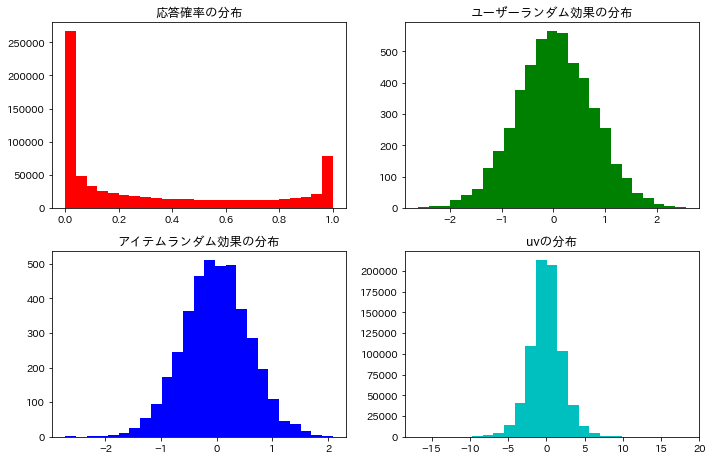

In [9]:
#潜在変数ごとのヒストグラム
dt = [Prob, beta1, beta2, uv]
fig_range = np.append(np.array([0, np.min(beta1), np.min(beta2), np.min(uv)]), 
                      np.array([1.0, np.max(beta1), np.max(beta2), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答確率の分布", "ユーザーランダム効果の分布", "アイテムランダム効果の分布", "uvの分布"]
fig = plt.figure(figsize=(10.0, 6.5))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [10]:
####Binomial Probit Based Tucker Decompositionを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm1(mu, mu_vec, Sigma, record_id1, record_id2, index_record1, index_record2, a, b, N, N1, N2):
    U = np.repeat(0.0, N)
    FA = norm.cdf(a, mu, Sigma)
    FB = norm.cdf(b, mu, Sigma)
    U[index_record1] = norm.ppf(np.random.uniform(0, 1, N1)*(FB-FA)[record_id1]+FA[record_id1], mu_vec[index_record1], Sigma)
    U[index_record2] = norm.ppf(np.random.uniform(0, 1, N2)*FA[record_id2], mu_vec[index_record2], Sigma)
    return U

def rtnorm2(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [11]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [12]:
##アルゴリズムの設定
k = 10
R = 2000
keep = 10
burnin = int(100/keep)
iter = 0
disp = 10

In [13]:
##データの設定
#切断領域を定義
rho = 100.0
a = np.repeat(0.0, hhpt)
b = np.repeat(rho, hhpt)
flag =  y_vec - (1-y_vec)

#頻度を集計
d_freq = np.repeat(0, hh)
item_freq = np.repeat(0, item)
context_freq = np.repeat(0, context)
for i in range(hh):
    d_freq[i] = np.sum(freq[d_list[i]])
for i in range(item):
    item_freq[i] = np.sum(freq[item_list[i]])
for i in range(context):
    context_freq[i] = np.sum(freq[context_list[i]])

#レコードidを設定
intercept = np.repeat(1.0, hhpt)[:, np.newaxis]
record_id1 = np.repeat(np.arange(hhpt), data[:, 0])
record_id2 = np.repeat(np.arange(hhpt), data[:, 1])
index_record1 = np.array(np.where(y_vec==1)[0], dtype="int")
index_record2 = np.array(np.where(y_vec==0)[0], dtype="int")
N1 = index_record1.shape[0]
N2 = index_record2.shape[0]

#特徴行列の割当インデックス
allocation_u = np.repeat(np.arange(k1), k2)
allocation_v = np.tile(np.arange(k2), k1)
allocation_omega = np.array([np.delete(np.arange(k3), j).tolist() for j in range(k3)])

In [14]:
##事前分布の設定
#階層モデルの事前分布
V1 = 0.1 * np.diag(np.ones(k1+1))
V2 = 0.1 * np.diag(np.ones(k2+1))
nu = 1
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
alpha = np.array([0.0])
alpha_u = np.repeat(0.0, k1)
alpha_v = np.repeat(0.0, k2)
alpha_c = np.repeat(1.0, k3)
alpha_g = np.repeat(0.0, k1*k2)
Cov_c = np.diag(np.repeat(0.1, k3))
inv_Cov_c = np.linalg.inv(Cov_c)
Cov_g = np.diag(np.repeat(0.1, k1*k2))
inv_Cov_g = np.linalg.inv(Cov_g)
tau = 100 
s02 = 1.0
v02 = 1.0

In [15]:
##パラメータの真値
#階層モデルの分散の真値
tau1 = taut1.copy()
tau2 = taut2.copy()
Cov_u = Covt_u.copy()
Cov_v = Covt_v.copy()
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの真値
Sigma = np.array([1.0])
beta = betat.copy()
beta1 = betat1.copy()
beta2 = betat2.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_c = thetat_c.copy()
omega = omegat.copy()

#タッカー分解の期待値
uv = np.array(np.repeat(0.0, hhpt), dtype="float32")
beta_user = beta1[d_id]
beta_item = beta2[item_id]
theta_item = theta_v[item_id, ]
theta_context = theta_c[context_id, ]
for j in range(k3):
    uv += np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], vec_k2)
mu = beta + beta_user + beta_item + uv
mu_vec = mu[record_id]
mut = mu.copy()

In [16]:
##パラメータの初期値
#階層モデルの分散の初期値
tau1 = np.array([0.25])
tau2 = np.array([0.25])
Cov_u = np.diag(np.repeat(0.25, k1))
Cov_v = np.diag(np.repeat(0.25, k2))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの初期値
beta = np.array([-0.5])
beta1 = np.random.normal(0, tau1, hh)
beta2 = np.random.normal(0, tau2, item)
theta_u = np.random.multivariate_normal(alpha_u, Cov_u, hh)
theta_v = np.random.multivariate_normal(alpha_v, Cov_v, item)
theta_c = np.random.multivariate_normal(alpha_c, Cov_c, context)
omega = np.random.normal(0, 0.1, k1*k2*k3).reshape(k1, k2, k3)

#タッカー分解の期待値
uv = np.repeat(0.0, hhpt)
beta_user = beta1[d_id]
beta_item = beta2[item_id]
theta_item = theta_v[item_id, ]
theta_context = theta_c[context_id, ]
for j in range(k3):
    uv += np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], vec_k2)
mu = beta + beta_user + beta_item + uv
mu_vec = mu[record_id]

In [17]:
##パラメータの格納用配列
#階層モデルのパラメータの格納用配列
TAU1 = np.repeat(0.0, int(R/keep))
TAU2 = np.repeat(0.0, int(R/keep))
COV_U = np.zeros((k1, k1, int(R/keep)))
COV_V = np.zeros((k2, k2, int(R/keep)))
COV_C = np.zeros((k3, k3, int(R/keep)))

#モデルパラメータの格納用配列
BETA = np.repeat(0.0, int(R/keep))
BETA1 = np.zeros((int(R/keep), hh))
BETA2 = np.zeros((int(R/keep), item))
THETA_U = np.zeros((hh, k1, int(R/keep)))
THETA_V = np.zeros((item, k2, int(R/keep)))
THETA_C = np.zeros((context, k3, int(R/keep)))
OMEGA = np.zeros((k1, k2, k3, int(R/keep)))

In [18]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
Prob = np.sum(y)/N
LLst = np.sum(y*np.log(Prob) + (freq-y)*np.log(1-Prob))
print(LLst)

#真値での対数尤度
Prob = norm.cdf(mut, 0, Sigma)
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest = np.sum(y*np.log(Prob) + (freq-y)*np.log(1-Prob))
print(LLbest)

-12032903.474381281
-5274131.718345054


In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##切断正規分布から潜在効用を生成
    #モデルの期待値
    mu = beta + beta_user + beta_item + uv
    mu_vec = mu[record_id]

    #潜在効用を生成
    u_vec = rtnorm1(mu, mu_vec, Sigma, record_id1, record_id2, index_record1, index_record2, a, b, N, N1, N2)
    index_inf = np.array(np.where(np.isinf(u_vec)==True)[0], dtype="int")
    m = index_inf.shape[0]
    u_vec[index_inf] = y_vec[index_inf]*rtnorm2(0, Sigma, 0, 1, m) + (1-y_vec[index_inf])*rtnorm2(0, Sigma, 0, 1, m)
    U = np.dot(record_dt, sparse.csr_matrix(u_vec).T).toarray().reshape(-1)

    
    ##モデルの期待値パラメータをサンプリング
    #データの定義
    Sigma_sq = np.power(Sigma, 2)
    er_y = U - freq*beta_user - freq*beta_item - freq*uv

    #正規分布から期待値をサンプリング
    weights = np.power(tau, 2) / (Sigma_sq/N + np.power(tau, 2))
    mu_par = weights*np.sum(er_y)/N
    beta = np.random.normal(mu_par, weights*Sigma_sq/N, 1)


    ##ユーザーパラメータをサンプリング
    #モデル誤差を定義
    alpha_prior = np.append(alpha, alpha_u)
    inv_Cov = np.diag(np.append(1/tau1, np.diag(inv_Cov_u)))
    er_y = U - freq*beta - freq*beta_item

    #新しい入力変数を生成
    X = np.zeros((hhpt, k1))
    for j in range(k3):
        X += np.dot(theta_v, omega[:, :, j].T)[item_id, ] * theta_context[:, j][:, np.newaxis]
    X = np.hstack((intercept, X))

    #多変量正規分布から事後分布をサンプリング
    theta = np.zeros((hh, k1+1))
    for i in range(hh):
        index = d_list[i]
        x = X[index, ]
        xy = np.dot(x.T, er_y[index])
        xxv = np.dot(freq[index]*x.T, x) + inv_Cov
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov, alpha_prior))
        theta[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)

    #パラメータを更新
    beta1 = theta[:, 0]; theta_u = theta[:, 1:]
    beta_user = beta1[d_id]; theta_user = theta_u[d_id, ]


    ##アイテムパラメータをサンプリング
    #モデル誤差を定義
    alpha_prior = np.append(alpha, alpha_v)
    inv_Cov = np.diag(np.append(1/tau2, np.diag(inv_Cov_v)))
    er_y = U - freq*beta - freq*beta_user

    #新しい入力変数を生成
    X = np.zeros((hhpt, k2))
    for j in range(k3):
        X += np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_context[:, j][:, np.newaxis]
    X = np.hstack((intercept, X))

    #多変量正規分布から事後分布をサンプリング
    theta = np.zeros((item, k2+1))
    for i in range(item):
        index = item_list[i]
        x = X[index, ]
        xy = np.dot(x.T, er_y[index])
        xxv = np.dot(freq[index]*x.T, x) + inv_Cov
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov, alpha_prior))
        theta[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)

    #パラメータを更新
    beta2 = theta[:, 0]; theta_v = theta[:, 1:]
    beta_item = beta2[item_id]; theta_item = theta_v[item_id, ]


    ##コンテキストパラメータをサンプリング
    #モデル誤差を定義
    er_y = U - freq*beta - freq*beta_user - freq*beta_item

    #新しい入力変数を生成
    X = np.zeros((hhpt, k3))
    for j in range(k3):
        X[:, j] = np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item, vec_k2)

    #多変量正規分布から事後分布をサンプリング
    for i in range(context):
        index = context_list[i]
        x = X[index, ]
        xy = np.dot(x.T, er_y[index])
        xxv = np.dot(freq[index]*x.T, x) + inv_Cov_c
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_c, alpha_c))
        theta_c[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)

    #パラメータを更新
    theta_context = theta_c[context_id, ]


    ##コアテンソルをサンプリング
    #タッカー分解の期待値を展開
    uv_deploy = np.zeros((hhpt, k3))
    for j in range(k3):
        uv_deploy[:, j] = np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], vec_k2)
    theta_deploy = theta_u[:, allocation_u][d_id, ] * theta_v[:, allocation_v][item_id, ]
    target_y = U - freq*beta - freq*beta_user - freq*beta_item

    #多変量正規分布から事後分布をサンプリング
    for j in range(k3):
        er_y = target_y - freq*np.dot(uv_deploy[:, allocation_omega[j, ]], np.repeat(1, k3-1))   #モデル誤差
        x = theta_deploy * theta_context[:, j][:, np.newaxis]
        xy = np.dot(x.T, er_y)
        xxv = np.dot(freq*x.T, x) + inv_Cov_g
        inv_xxv = np.linalg.inv(xxv)
        omega_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_g, alpha_g))
        omega[:, :, j] = np.random.multivariate_normal(omega_par, Sigma_sq*inv_xxv, 1).reshape(k1, k2)
        uv_deploy[:, j] = np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], vec_k2)

    #タッカー分解の期待値を更新
    uv = np.repeat(0.0, hhpt)
    for j in range(k3):
        uv += np.dot(np.dot(theta_u, omega[:, :, j])[d_id, ] * theta_item * theta_context[:, j][:, np.newaxis], vec_k2)
    mu = beta + beta_user + beta_item + uv
    mu_vec = mu[record_id]


    ##ユーザーパラメータの階層モデルの分散共分散行列をサンプリング
    #データを定義
    theta = np.hstack((beta1[:, np.newaxis], theta_u))
    er = theta - np.mean(theta, axis=0)

    #逆ウィシャート分布から事後分布をサンプリング
    IW_R = np.dot(er.T, er) + V1
    Sn = hh + nu
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)

    #パラメータを更新
    tau1 = np.diag(Cov)[0]
    Cov_u = np.diag(np.diag(Cov)[1:])
    inv_Cov_u = np.linalg.inv(Cov_u)

    ##アイテムパラメータの階層モデルの分散共分散行列をサンプリング
    #データを定義
    theta = np.hstack((beta2[:, np.newaxis], theta_v))
    er = theta - np.mean(theta, axis=0)

    #逆ウィシャート分布から事後分布をサンプリング
    IW_R = np.dot(er.T, er) + V2
    Sn = item + nu
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)

    #パラメータを更新
    tau2 = np.diag(Cov)[0]
    Cov_v = np.diag(np.diag(Cov)[1:])
    inv_Cov_v = np.linalg.inv(Cov_v)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        #サンプリング結果の格納
        mkeep = int(rp/keep)
        TAU1[mkeep] = tau1
        TAU2[mkeep] = tau2
        COV_U[:, :, mkeep] = Cov_u
        COV_V[:, :, mkeep] = Cov_v
        COV_C[:, :, mkeep] = Cov_c
        BETA[mkeep] = beta
        BETA1[mkeep, ] = beta1
        BETA2[mkeep, ] = beta2
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_C[:, :, mkeep] = theta_c
        OMEGA[:, :, :, mkeep] = omega

        #学習データに対する対数尤度を更新
        Prob = norm.cdf(mu, 0, Sigma)
        Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
        LL = np.sum(y*np.log(Prob) + (freq-y)*np.log(1-Prob))

        #サンプリング結果の表示
        print(rp)
        print([np.round(LL, 1), np.round(LLbest, 1), np.round(LLst, 1)])

0
[-11062940.9, -5274131.7, -12032903.5]
10
[-6488830.8, -5274131.7, -12032903.5]
20
[-6199078.2, -5274131.7, -12032903.5]
30
[-6050647.1, -5274131.7, -12032903.5]
40
[-5915416.5, -5274131.7, -12032903.5]
50
[-5790840.3, -5274131.7, -12032903.5]
60
[-5695511.3, -5274131.7, -12032903.5]
70
[-5622688.4, -5274131.7, -12032903.5]
80
[-5568808.5, -5274131.7, -12032903.5]
90
[-5526733.9, -5274131.7, -12032903.5]
100
[-5494986.8, -5274131.7, -12032903.5]
110
[-5470552.1, -5274131.7, -12032903.5]
120
[-5450379.9, -5274131.7, -12032903.5]
130
[-5432754.8, -5274131.7, -12032903.5]
140
[-5417843.7, -5274131.7, -12032903.5]
150
[-5403772.9, -5274131.7, -12032903.5]
160
[-5390510.3, -5274131.7, -12032903.5]
170
[-5378658.2, -5274131.7, -12032903.5]
180
[-5367553.6, -5274131.7, -12032903.5]
190
[-5357334.6, -5274131.7, -12032903.5]
200
[-5348223.2, -5274131.7, -12032903.5]
210
[-5339779.1, -5274131.7, -12032903.5]
220
[-5332381.4, -5274131.7, -12032903.5]
230
[-5325857.5, -5274131.7, -12032903.5]
24